<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/AA_GRUPO3/blob/main/PFG_RNN_Predictiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
pip install unidecode

In [40]:
import os
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt
import unicodedata

In [ ]:
# Asegúrarse de cambiar la ruta por el nombre real de la carpeta en Google Drive
folder_path = '/content/drive/My Drive/PFG_FASPAS/RNN'
docs_xlsx = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]
print(docs_xlsx)

['df_8000_rows.xlsx', 'PROVINCIA_MUNICIPIO.xlsx', 'RN_AT.xlsx', 'RN_ACT.xlsx', 'RN_LOG.xlsx', 'RN_EM.xlsx', 'RN_SAAF.xlsx', 'RN_SO.xlsx']


In [ ]:
dic_dataframes = {}

for doc in docs_xlsx:
    entire_path = os.path.join(folder_path, doc)
    df = pd.read_excel(entire_path)
    # Uso el nombre del archivo como clave
    dic_dataframes[doc] = df

# Imprimir todas las claves
for clave in dic_dataframes.keys():
    print(clave)

df_8000_rows.xlsx
PROVINCIA_MUNICIPIO.xlsx
RN_AT.xlsx
RN_ACT.xlsx
RN_LOG.xlsx
RN_EM.xlsx
RN_SAAF.xlsx
RN_SO.xlsx


In [ ]:
RN_SAAF = dic_dataframes.get("RN_SAAF.xlsx")
RN_AT = dic_dataframes.get("RN_AT.xlsx")
RN_EM = dic_dataframes.get("RN_EM.xlsx")
RN_SO = dic_dataframes.get("RN_SO.xlsx")
RN_LOG = dic_dataframes.get("RN_LOG.xlsx")
df_8000rows = dic_dataframes.get("df_8000_rows.xlsx")
provincia_municipio = dic_dataframes.get('PROVINCIA_MUNICIPIO.xlsx')

In [41]:
# CÓDIGO SOLO PARA EL CURRO (PQ NO PUEDO ACCEDER AL DRIVE)
RN_SAAF = pd.read_excel('/content/RN_SAAF.xlsx')
RN_AT = pd.read_excel('/content/RN_AT.xlsx')
# RN_ACT = pd.read_excel('/content/RN_ACT.xlsx')
RN_EM = pd.read_excel('/content/RN_EM.xlsx')
RN_LOG = pd.read_excel('/content/RN_LOG.xlsx')
RN_SO = pd.read_excel('/content/RN_SO.xlsx')
df_8000rows = pd.read_excel('/content/df_8000_rows.xlsx')
provincia_municipio = pd.read_excel('/content/PROVINCIA_MUNICIPIO.xlsx')

In [42]:
# Convert all string columns to uppercase and remove accents/diacritics in combined_df
df_8000rows = df_8000rows.applymap(lambda x: unidecode(x.upper()) if isinstance(x, str) else x)
provincia_municipio = provincia_municipio.applymap(lambda x: unidecode(x.upper()) if isinstance(x, str) else x)

In [43]:
# Function to add PROVINCIA column based on LOCALIDAD
def add_provincia_column(df, provincia_mapping):
    df['PROVINCIA'] = df['LOCALIDAD'].map(provincia_mapping)
    return df

# Create a dictionary mapping from LOCALIDAD to PROVINCIA
localidad_to_provincia = provincia_municipio.set_index('MUNICIPIO')['PROVINCIA'].to_dict()

# List of RN dataframes to process
rn_dataframes = {'AT': RN_AT, 'EM': RN_EM, 'LOG': RN_LOG, 'SAAF': RN_SAAF, 'SO': RN_SO}

# Add the PROVINCIA column to each RN dataframe
rn_dfs_with_provincia = {name: add_provincia_column(df, localidad_to_provincia) for name, df in rn_dataframes.items()}

# Drop rows with null values in the 'PROVINCIA' column in each RN dataframe
rn_dfs_cleaned = {name: df.dropna(subset=['PROVINCIA']) for name, df in rn_dfs_with_provincia.items()}

In [44]:
# List of columns to keep
required_columns = ['LOCALIDAD', 'GENERO', 'YEAR NACIMIENTO', 'PROVINCIA']

# Function to ensure the dataframe has all required columns
def ensure_columns(df, columns):
    for column in columns:
        if column not in df.columns:
            df[column] = np.nan  # Create column with NaN values if it does not exist
    return df[columns]  # Return dataframe with only the required columns

# Ensure all dataframes have the required columns
rn_dfs_final = {name: ensure_columns(df, required_columns) for name, df in rn_dfs_cleaned.items()}

<ipython-input-44-605fc2068a84>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = np.nan  # Create column with NaN values if it does not exist


In [45]:
# Mapping dictionary for normalizing gender values
gender_mapping = {
    'FEMENINO': 'MUJER',
    'M': 'MUJER',
    'MASCULINO': 'HOMBRE',
    'H': 'HOMBRE'
}

# Function to normalize the 'GENERO' column in a dataframe
def normalize_gender_column(df):
    df['GENERO'] = df['GENERO'].map(lambda x: gender_mapping.get(x, x))
    return df

# Apply the normalization to the 'SO' dataframe
rn_dfs_final['SO'] = normalize_gender_column(rn_dfs_final['SO'])

<ipython-input-45-333b05a14062>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GENERO'] = df['GENERO'].map(lambda x: gender_mapping.get(x, x))


In [46]:
# Function to insert random registers into a dataframe where the 'GENERO' column is empty
def insert_random_registers(df, gender_distribution):
    # Find the indices where 'GENERO' is empty
    empty_indices = df[df['GENERO'].isna()].index

    # Generate random genders based on the given distribution for the empty indices
    genders = np.random.choice(
        ['MUJER', 'HOMBRE'],
        size=len(empty_indices),
        p=[gender_distribution['MUJER'], gender_distribution['HOMBRE']]
    )

    # Assign these random genders to the empty 'GENERO' rows
    df.loc[empty_indices, 'GENERO'] = genders
    return df

# Example of usage
gender_distribution = {'MUJER': 0.44, 'HOMBRE': 0.56}

# Insert random registers into a specific dataframe, e.g., 'ACT', where 'GENERO' is empty
rn_dfs_final['SAAF'] = insert_random_registers(rn_dfs_final['SAAF'], gender_distribution)
rn_dfs_final['SO'] = insert_random_registers(rn_dfs_final['SO'], gender_distribution)

In [47]:
# Get the min and max year in the 'YEAR NACIMIENTO' column
min_year = int(rn_dfs_final['SO']['YEAR NACIMIENTO'].min())
max_year = int(rn_dfs_final['SO']['YEAR NACIMIENTO'].max())

# Function to generate random years with the specified distribution
def generate_random_years(size):
    # 75% of the years under 2004
    under_2004 = np.random.randint(min_year, 2004, size=int(size * 0.75))
    # 25% of the years between 2004 and max_year
    over_2004 = np.random.randint(2004, max_year + 1, size=size - int(size * 0.75))
    return np.concatenate([under_2004, over_2004])

# Function to insert random years into the 'YEAR NACIMIENTO' column where it is empty
def insert_random_years(df):
    # Find the indices where 'YEAR NACIMIENTO' is empty
    empty_indices = df[df['YEAR NACIMIENTO'].isna()].index

    # Generate random years based on the specified distribution
    random_years = generate_random_years(len(empty_indices))
    np.random.shuffle(random_years)  # Shuffle to mix the values

    # Assign these random years to the empty 'YEAR NACIMIENTO' rows
    df.loc[empty_indices, 'YEAR NACIMIENTO'] = random_years
    return df

# Apply the function to the 'SO' dataframe
rn_dfs_final['SO'] = insert_random_years(rn_dfs_final['SO'])

In [48]:
# Add a column named 'SERVICIO' with the name of the dataframe to each dataframe in rn_dfs_final
def add_servicio_column(dfs):
    for name, df in dfs.items():
        df['SERVICIO'] = name
    return dfs

# Apply the function to rn_dfs_final
rn_dfs_final = add_servicio_column(rn_dfs_final)

<ipython-input-48-c5260d67a514>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SERVICIO'] = name
<ipython-input-48-c5260d67a514>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SERVICIO'] = name
<ipython-input-48-c5260d67a514>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [49]:
# Combine all dataframes into a single dataframe
combined_df = pd.concat(rn_dfs_final.values(), ignore_index=True)

# Shuffle the rows of the combined dataframe
shuffled_combined_df = combined_df.sample(frac=1).reset_index(drop=True)

shuffled_combined_df['SERVICIO'].value_counts()

SERVICIO
SO      1457
SAAF     567
EM       203
LOG      182
AT       143
Name: count, dtype: int64

In [50]:
# Crear una función para categorizar por grupos de edad
def categorize_age(year):
    if year < 1940:
        return 'ANTES DE 1940'
    elif year < 1960:
        return '1940-1959'
    elif year < 1980:
        return '1960-1979'
    elif year < 2000:
        return '1980-1999'
    elif year < 2020:
        return '2000-2020'
    else:
        return '2020 EN ADELANTE'

rna1 = shuffled_combined_df.copy()
# Aplicar la función a la columna 'YEAR NACIMIENTO'
rna1['YEAR NACIMIENTO_CAT'] = rna1['YEAR NACIMIENTO'].apply(categorize_age)

# Ver el resultado
print(rna1)

                   LOCALIDAD  GENERO  YEAR NACIMIENTO    PROVINCIA SERVICIO  \
0                GUADALAJARA   MUJER           1975.0  GUADALAJARA       SO   
1     VILLAMAYOR DE SANTIAGO   MUJER           1999.0       CUENCA       SO   
2                     TOLEDO   MUJER           1985.0       TOLEDO       SO   
3                   ALBACETE   MUJER           1931.0     ALBACETE       SO   
4                   ALBACETE  HOMBRE           1970.0     ALBACETE       SO   
...                      ...     ...              ...          ...      ...   
2547     CABANAS DE LA SAGRA   MUJER           1974.0       TOLEDO       SO   
2548                  TOLEDO   MUJER           1989.0       TOLEDO       SO   
2549                  TOLEDO   MUJER           2008.0       TOLEDO      LOG   
2550                  TOLEDO   MUJER           1938.0       TOLEDO       SO   
2551             GUADALAJARA   MUJER           1975.0  GUADALAJARA       SO   

     YEAR NACIMIENTO_CAT  
0              1960-1979

#Análisis descriptivo de los datos
Análisis descriptivo de los datos por servicio, vamos a ver cómo se distribuyen y qué peso tiene cada servicio en la totalidad de CLM.

**OJOOOOO** SE DEBE COMENTAR LA PARTE DEL ANÁLISIS DESCRIPTIVO PARA EJECUTAR EL CÓDIGO DE LAS RNAS.

In [ ]:
df['YEAR NACIMIENTO'].unique()

array([  nan, 1980., 2003., 2007., 1976., 1972., 2010., 1947., 1977.,
       2011., 1981., 1979., 2015., 1959., 1966., 2014., 1974., 2006.,
       2005., 1969., 1968., 1971., 1975., 2013., 1983., 2012., 2016.,
       1996., 1989., 1978., 1999., 2004., 2017., 1984., 1987., 2018.,
       1954., 1995., 1991., 2008., 1955., 1952., 1951., 1957., 1958.,
       1964., 1953., 1956., 2020., 1961., 1988., 2009., 1982., 1985.,
       2021., 1970., 1998., 2002., 1943., 1967., 2000., 1950., 1944.,
       1965., 1935., 1992., 1986., 1997., 2001., 1994., 1949., 1990.,
       2019., 1993., 1973., 1960., 1963., 1929., 1945., 1939., 1962.,
       1948.])

In [ ]:
df = rna1.copy()


# Función para calcular la moda con manejo de posibles errores
def mode(series):
    if len(series) == 0:
        return np.nan
    return series.mode().iloc[0]

# Calcular las medidas de tendencia central y dispersión por servicio
descriptive_stats = df.groupby('SERVICIO')['YEAR NACIMIENTO'].agg(['mean', 'median', mode, 'var', 'std', 'min', 'max'])
descriptive_stats['range'] = descriptive_stats['max'] - descriptive_stats['min']

# Mostrar los resultados
display(descriptive_stats)

# Tablas de contingencia
# Contingencia de GENERO por SERVICIO
contingency_gender_service = pd.crosstab(df['SERVICIO'], df['GENERO'])

# Contingencia de PROVINCIA por SERVICIO
contingency_provincia_service = pd.crosstab(df['SERVICIO'], df['PROVINCIA'])

# Contingencia de PROVINCIA por SERVICIO
contingency_year_service = pd.crosstab(df['SERVICIO'], df['YEAR NACIMIENTO_CAT'])

# Mostrar las tablas de contingencia
print("\nContingencia de Genero por Servicio:")
display(contingency_gender_service)

print("\nContingencia de Provincia por Servicio:")
display(contingency_provincia_service)

print("\nContingencia de Año por Servicio:")
display(contingency_year_service)

,mean,median,mode,var,std,min,max,range
SERVICIO,,,,,,,,
AT,2019.475524,2020.0,2020.0,2.237073,1.495685,2016.0,2023.0,7.0
EM,1980.800000,1979.0,1973.0,146.629787,12.109079,1957.0,2003.0,46.0
LOG,2003.804469,2010.0,2015.0,322.236834,17.950956,1941.0,2020.0,79.0
SAAF,1994.918871,2001.0,2016.0,461.890933,21.491648,1905.0,2024.0,119.0
SO,1982.035003,1981.0,2007.0,600.434900,24.503773,1929.0,2021.0,92.0



Contingencia de Genero por Servicio:


GENERO,HOMBRE,MUJER
SERVICIO,,
AT,93,50
EM,102,101
LOG,106,76
SAAF,317,250
SO,736,721



Contingencia de Provincia por Servicio:


PROVINCIA,ALBACETE,CIUDAD REAL,CUENCA,GUADALAJARA,TOLEDO
SERVICIO,,,,,
AT,47,35,8,0,53
EM,27,98,10,2,66
LOG,0,0,35,61,86
SAAF,114,151,73,138,91
SO,252,70,67,650,418



Contingencia de Año por Servicio:


YEAR NACIMIENTO_CAT,1940-1959,1960-1979,1980-1999,2000-2020,2020 EN ADELANTE,ANTES DE 1940
SERVICIO,,,,,,
AT,0,0,0,66,77,0
EM,2,48,38,7,108,0
LOG,10,13,14,138,7,0
SAAF,49,91,129,260,35,3
SO,234,386,306,434,19,78


##RNA predictiva con los datos reales
Vamos a realizar una primera red neuronal con los registros reales.

####Preparación de los datos

Convertimos las variables categóricas en variables dummy usando pd.get_dummies.

Separamos las características (x) de la etiqueta (y).
Convertimos la etiqueta en variables dummy para la clasificación multiclase.

In [56]:
rna1.dtypes

LOCALIDAD               object
GENERO                  object
YEAR NACIMIENTO        float64
PROVINCIA               object
SERVICIO                object
YEAR NACIMIENTO_CAT     object
dtype: object

In [63]:
# Convertir las variables categóricas en variables dummy
df = pd.get_dummies(rna1, columns=['LOCALIDAD', 'GENERO', 'PROVINCIA', 'YEAR NACIMIENTO', 'YEAR NACIMIENTO_CAT'])

# Separar las características (X) y la etiqueta (y)
X = df.drop('SERVICIO', axis=1)
y = df['SERVICIO']

# Convertir la etiqueta en variables dummy
y = pd.get_dummies(y)

####División de los datos
Usaremos un 70% de los datos para entrenar y del 30% restante, un 70% para validar (21% del total) e ir ajustandio los hiperparámetros (evitando el sobreentrenamiento) y un 30% para el conjunto de test (9% del total), para evaluar el modelo y su precisión al final.

In [64]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

# Verificar las formas de los conjuntos de datos
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (1786, 325)
Tamaño del conjunto de validación: (536, 325)
Tamaño del conjunto de prueba: (230, 325)


In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Definir el modelo
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/50
56/56 [==============================] - 1s 7ms/step - loss: 1.2931 - accuracy: 0.5011 - val_loss: 1.1112 - val_accuracy: 0.5653
Epoch 2/50
56/56 [==============================] - 0s 4ms/step - loss: 1.1048 - accuracy: 0.5784 - val_loss: 1.0394 - val_accuracy: 0.5653
Epoch 3/50
56/56 [==============================] - 0s 4ms/step - loss: 1.0458 - accuracy: 0.5817 - val_loss: 0.9988 - val_accuracy: 0.5896
Epoch 4/50
56/56 [==============================] - 0s 3ms/step - loss: 1.0025 - accuracy: 0.6025 - val_loss: 0.9432 - val_accuracy: 0.6325
Epoch 5/50
56/56 [==============================] - 0s 3ms/step - loss: 0.9590 - accuracy: 0.6277 - val_loss: 0.8886 - val_accuracy: 0.6660
Epoch 6/50
56/56 [==============================] - 0s 4ms/step - loss: 0.9106 - accuracy: 0.6495 - val_loss: 0.8425 - val_accuracy: 0.6884
Epoch 7/50
56/56 [==============================] - 0s 3ms/step - loss: 0.8619 - accuracy: 0.6618 - val_loss: 0.8031 - val_accuracy: 0.7015
Epoch 8/50
56/56 [==

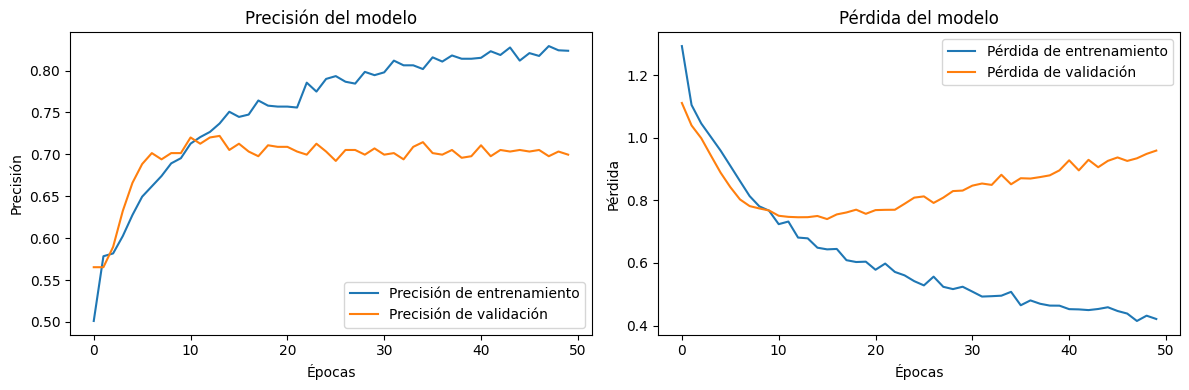

In [68]:
# Graficar la precisión del modelo
plt.figure(figsize=(12, 4))

# Gráfica de la precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de la pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, tanh

# Definir el modelo con hiperparámetros ajustables
def create_model(learning_rate=0.001, activation='relu', dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Crear el modelo con hiperparámetros ajustados
model = create_model(learning_rate=0.0005, activation='tanh', dropout_rate=0.3)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/100
28/28 [==============================] - 2s 20ms/step - loss: 1.3585 - accuracy: 0.4866 - val_loss: 1.1422 - val_accuracy: 0.5653
Epoch 2/100
28/28 [==============================] - 0s 8ms/step - loss: 1.0923 - accuracy: 0.5879 - val_loss: 1.0276 - val_accuracy: 0.5802
Epoch 3/100
28/28 [==============================] - 0s 8ms/step - loss: 1.0014 - accuracy: 0.6344 - val_loss: 0.9502 - val_accuracy: 0.6698
Epoch 4/100
28/28 [==============================] - 0s 6ms/step - loss: 0.9491 - accuracy: 0.6618 - val_loss: 0.9045 - val_accuracy: 0.6735
Epoch 5/100
28/28 [==============================] - 0s 8ms/step - loss: 0.9088 - accuracy: 0.6803 - val_loss: 0.8678 - val_accuracy: 0.6884
Epoch 6/100
28/28 [==============================] - 0s 10ms/step - loss: 0.8667 - accuracy: 0.6792 - val_loss: 0.8374 - val_accuracy: 0.7015
Epoch 7/100
28/28 [==============================] - 0s 9ms/step - loss: 0.8319 - accuracy: 0.6920 - val_loss: 0.8205 - val_accuracy: 0.7015
Epoch 8/100

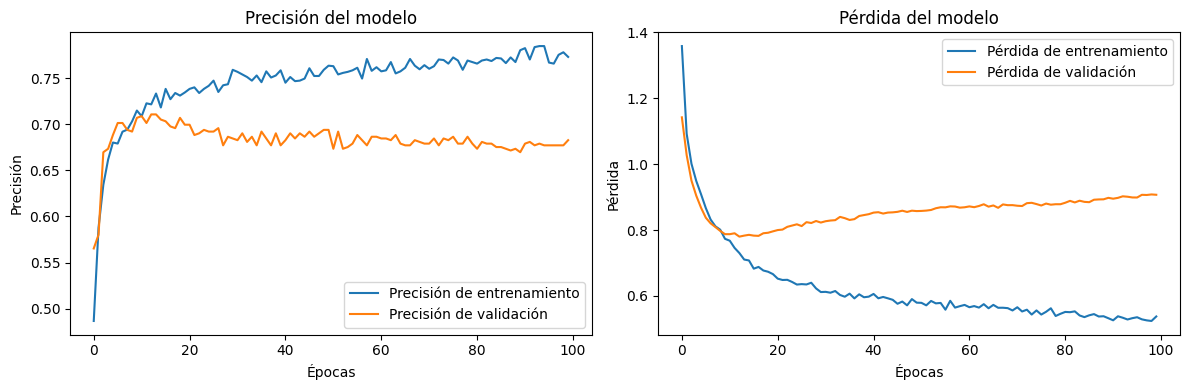

In [70]:
# Graficar la precisión del modelo
plt.figure(figsize=(12, 4))

# Gráfica de la precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de la pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Definir el modelo con hiperparámetros ajustables
def create_simple_model(learning_rate=0.001, dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Crear el modelo con hiperparámetros ajustados
model = create_simple_model(learning_rate=0.001, dropout_rate=0.3)

# Añadir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/50
56/56 [==============================] - 1s 7ms/step - loss: 1.3757 - accuracy: 0.5106 - val_loss: 1.1609 - val_accuracy: 0.5653
Epoch 2/50
56/56 [==============================] - 0s 3ms/step - loss: 1.1267 - accuracy: 0.5784 - val_loss: 1.0577 - val_accuracy: 0.5653
Epoch 3/50
56/56 [==============================] - 0s 3ms/step - loss: 1.0680 - accuracy: 0.5845 - val_loss: 1.0045 - val_accuracy: 0.5840
Epoch 4/50
56/56 [==============================] - 0s 3ms/step - loss: 1.0140 - accuracy: 0.5901 - val_loss: 0.9692 - val_accuracy: 0.5970
Epoch 5/50
56/56 [==============================] - 0s 3ms/step - loss: 0.9599 - accuracy: 0.6165 - val_loss: 0.9319 - val_accuracy: 0.6418
Epoch 6/50
56/56 [==============================] - 0s 4ms/step - loss: 0.9151 - accuracy: 0.6433 - val_loss: 0.8915 - val_accuracy: 0.6679
Epoch 7/50
56/56 [==============================] - 0s 4ms/step - loss: 0.8826 - accuracy: 0.6562 - val_loss: 0.8515 - val_accuracy: 0.6959
Epoch 8/50
56/56 [==

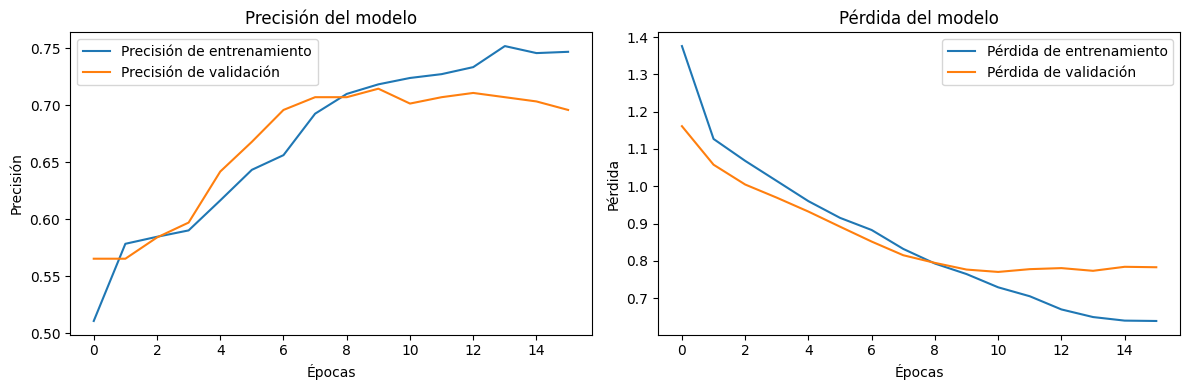

In [72]:
# Graficar la precisión del modelo
plt.figure(figsize=(12, 4))

# Gráfica de la precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de la pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

###Modelo XGBoost

In [73]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Codificar las etiquetas usando LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.idxmax(axis=1))  # Convertir de one-hot encoding a etiquetas enteras

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Crear y entrenar el modelo XGBoost
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=len(label_encoder.classes_))
xgb_model.fit(X_train_xgb, y_train_xgb)

# Obtener las predicciones de probabilidad del conjunto de prueba
X_train_nn = xgb_model.predict_proba(X_train_xgb)
X_test_nn = xgb_model.predict_proba(X_test_xgb)

# Convertir las etiquetas del conjunto de prueba a one-hot encoding
y_train_nn = to_categorical(y_train_xgb, num_classes=len(label_encoder.classes_))
y_test_nn = to_categorical(y_test_xgb, num_classes=len(label_encoder.classes_))

# Definir el modelo de red neuronal
def create_nn_model(input_dim, learning_rate=0.001, dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y_train_nn.shape[1], activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Crear el modelo de red neuronal
nn_model = create_nn_model(input_dim=X_train_nn.shape[1])

# Añadir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo de red neuronal
history = nn_model.fit(X_train_nn, y_train_nn, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = nn_model.evaluate(X_test_nn, y_test_nn)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/100
23/23 [==============================] - 1s 13ms/step - loss: 1.4809 - accuracy: 0.5245 - val_loss: 1.2522 - val_accuracy: 0.6201
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 1.0390 - accuracy: 0.6036 - val_loss: 0.8457 - val_accuracy: 0.6285
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.7994 - accuracy: 0.7080 - val_loss: 0.6844 - val_accuracy: 0.7598
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 0.6669 - accuracy: 0.7640 - val_loss: 0.6106 - val_accuracy: 0.7737
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 0.6172 - accuracy: 0.7647 - val_loss: 0.5940 - val_accuracy: 0.7430
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5785 - accuracy: 0.7766 - val_loss: 0.5930 - val_accuracy: 0.7709
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5855 - accuracy: 0.7857 - val_loss: 0.5741 - val_accuracy: 0.7961
Epoch 8/100


In [ ]:
# Graficar la precisión del modelo
plt.figure(figsize=(12, 4))

# Gráfica de la precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de la pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [ ]:
# Ejemplo de un registro individual (preprocesado) con el conjunto de prueba de XGBoost
new_record_xgb = X_test_xgb.iloc[3]

# Convertir el nuevo registro a un DataFrame
new_record_xgb_df = pd.DataFrame([new_record_xgb])

# Obtener las predicciones de probabilidad del modelo XGBoost
new_record_nn_input = xgb_model.predict_proba(new_record_xgb_df)

# Predecir usando el modelo de red neuronal entrenado
predictions = nn_model.predict(new_record_nn_input)

# Obtener las probabilidades para cada tipo de servicio
service_probabilities = predictions[0]

# Obtener el servicio objetivo original
original_service = y_test_xgb[3]  # Indexar directamente el array de NumPy

# Convertir el servicio objetivo original a etiqueta de texto
original_service_label = label_encoder.inverse_transform([original_service])[0]

# Imprimir el servicio objetivo original y las probabilidades
service_labels = label_encoder.classes_  # Obtener las etiquetas originales
print(f"Original Servicio: {original_service_label}")
for label, prob in zip(service_labels, service_probabilities):
    print(f"Servicio: {label}, Probabilidad: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Original Servicio: SO
Servicio: AT, Probabilidad: 0.0001
Servicio: EM, Probabilidad: 0.0036
Servicio: LOG, Probabilidad: 0.0038
Servicio: SAAF, Probabilidad: 0.2018
Servicio: SO, Probabilidad: 0.7907


In [ ]:
import numpy as np

# Ejemplo de un registro individual (preprocesado) con el conjunto de prueba de XGBoost
new_record_xgb = X_test_xgb.iloc[22]

# Convertir el nuevo registro a un DataFrame
new_record_xgb_df = pd.DataFrame([new_record_xgb])

# Obtener las predicciones de probabilidad del modelo XGBoost
new_record_nn_input = xgb_model.predict_proba(new_record_xgb_df)

# Predecir usando el modelo de red neuronal entrenado
predictions = nn_model.predict(new_record_nn_input)

# Obtener las probabilidades para cada tipo de servicio
service_probabilities = predictions[0]

# Obtener el servicio objetivo original
original_service = y_test_xgb[22]  # Indexar directamente el array de NumPy

# Convertir el servicio objetivo original a etiqueta de texto
original_service_label = label_encoder.inverse_transform([original_service])[0]

# Imprimir el servicio objetivo original y las probabilidades
service_labels = label_encoder.classes_  # Obtener las etiquetas originales
print(f"Original Servicio: {original_service_label}")
for label, prob in zip(service_labels, service_probabilities):
    print(f"Servicio: {label}, Probabilidad: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Original Servicio: SO
Servicio: AT, Probabilidad: 0.0001
Servicio: EM, Probabilidad: 0.0035
Servicio: LOG, Probabilidad: 0.0042
Servicio: SAAF, Probabilidad: 0.1932
Servicio: SO, Probabilidad: 0.7990


In [ ]:
# Ejemplo de un registro individual (preprocesado) con el conjunto de prueba de XGBoost
new_record_xgb = X_test_xgb.iloc[70]

# Convertir el nuevo registro a un DataFrame
new_record_xgb_df = pd.DataFrame([new_record_xgb])

# Obtener las predicciones de probabilidad del modelo XGBoost
new_record_nn_input = xgb_model.predict_proba(new_record_xgb_df)

# Predecir usando el modelo de red neuronal entrenado
predictions = nn_model.predict(new_record_nn_input)

# Obtener las probabilidades para cada tipo de servicio
service_probabilities = predictions[0]

# Obtener el servicio objetivo original
original_service = y_test_xgb[70]  # Indexar directamente el array de NumPy

# Convertir el servicio objetivo original a etiqueta de texto
original_service_label = label_encoder.inverse_transform([original_service])[0]

# Imprimir el servicio objetivo original y las probabilidades
service_labels = label_encoder.classes_  # Obtener las etiquetas originales
print(f"Original Servicio: {original_service_label}")
for label, prob in zip(service_labels, service_probabilities):
    print(f"Servicio: {label}, Probabilidad: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Original Servicio: EM
Servicio: AT, Probabilidad: 0.0400
Servicio: EM, Probabilidad: 0.8981
Servicio: LOG, Probabilidad: 0.0008
Servicio: SAAF, Probabilidad: 0.0416
Servicio: SO, Probabilidad: 0.0195


##RNA predictiva con datos generados
Red Neuronal con 8000 registros más que han sido creados teniendo en cuenta las estadísticas reales de los datos, es decir, contemplando cómo se distribuyen por edad, género y localidad y, obviamente, el municipio y la provincia correctamente computados.

Esto se hace para intentar aumentar el porcentaje de precisión obtenido.

In [74]:
# Calculate the frequency of each element in the 'SERVICIO' column
service_frequency = df['SERVICIO'].value_counts()

# Group by 'PROVINCIA' and 'SERVICIO' and count the occurrences
service_province_freq = shuffled_combined_df.groupby(['PROVINCIA', 'SERVICIO']).size().reset_index(name='COUNT')

# Function to assign services based on frequency
def assign_service(row, freq_df):
    province = row['PROVINCIA']
    possible_services = freq_df[freq_df['PROVINCIA'] == province]
    if possible_services.empty:
        return np.nan
    else:
        return np.random.choice(possible_services['SERVICIO'].values, p=possible_services['COUNT'].values / possible_services['COUNT'].sum())

# Apply the function to assign services
df_8000rows['SERVICIO'] = df_8000rows.apply(assign_service, axis=1, args=(service_province_freq,))

# Ensure balanced classes by sampling
min_class_size = service_frequency.min()
balanced_df = df_8000rows.groupby('SERVICIO').apply(lambda x: x.sample(n=min_class_size, replace=True)).reset_index(drop=True)

In [75]:
# Calculate the frequency of each service
service_frequency = shuffled_combined_df['SERVICIO'].value_counts()

# Set the target number of records per service
target_size = 1457

# Create a balanced dataframe starting with the initial shuffled data
to_use_df = shuffled_combined_df.copy()

# Loop through each service to balance the dataframe
for service, count in service_frequency.items():
    if count < target_size:
        # Get the rows for the current service
        service_df = balanced_df[balanced_df['SERVICIO'] == service]
        # Sample additional rows with replacement to reach the target size
        additional_samples = service_df.sample(n=target_size - count, replace=True)
        to_use_df = pd.concat([to_use_df, additional_samples])

# Shuffle the final balanced dataframe
to_use_df = to_use_df.sample(frac=1).reset_index(drop=True)

In [76]:
# Shuffle the rows of the dataframe ready to use
to_use_df = to_use_df.sample(frac=1).reset_index(drop=True)

In [77]:
# Get the min and max year in the 'YEAR NACIMIENTO' column
min_year = int(to_use_df['YEAR NACIMIENTO'].min())
max_year = int(to_use_df['YEAR NACIMIENTO'].max())

# Function to generate random years with the specified distribution
def generate_random_years(size):
    return np.random.randint(min_year, max_year + 1, size=int(size))

# Function to insert random years into the 'YEAR NACIMIENTO' column where it is empty
def insert_random_years(df):
    # Find the indices where 'YEAR NACIMIENTO' is empty
    empty_indices = df[df['YEAR NACIMIENTO'].isna()].index

    # Generate random years based on the specified distribution
    random_years = generate_random_years(len(empty_indices))

    # Assign these random years to the empty 'YEAR NACIMIENTO' rows
    df.loc[empty_indices, 'YEAR NACIMIENTO'] = random_years
    return df

# Apply the function to the dataframe
to_use_df = insert_random_years(to_use_df)

In [78]:
# Crear una función para categorizar por grupos de edad
def categorize_age(year):
    if year < 1940:
        return 'Antes de 1940'
    elif year < 1960:
        return '1940-1959'
    elif year < 1980:
        return '1960-1979'
    elif year < 2000:
        return '1980-1999'
    else:
        return '2000 en adelante'

# Aplicar la función a la columna 'YEAR NACIMIENTO'
to_use_df['YEAR NACIMIENTO'] = to_use_df['YEAR NACIMIENTO'].apply(categorize_age)

# Ver el resultado
print(to_use_df.head())

          LOCALIDAD  GENERO   YEAR NACIMIENTO    PROVINCIA SERVICIO
0         LA MINOSA  HOMBRE         1980-1999  GUADALAJARA      LOG
1  VILLAR Y VELASCO   MUJER         1980-1999       CUENCA      LOG
2             YELES  HOMBRE         1960-1979       TOLEDO     SAAF
3            CUENCA   MUJER  2000 en adelante       CUENCA       SO
4        HIGUERUELA  HOMBRE         1940-1959     ALBACETE       SO


In [79]:
# Determina la cantidad de servicios únicos
unique_services = to_use_df['SERVICIO'].unique()
num_services = len(unique_services)

# Determina cuántos registros por servicio necesitas para el conjunto de prueba
test_size_per_service = 85 // num_services

# Si hay más de 85 registros, ajusta la muestra para que esté balanceada
if test_size_per_service * num_services < 85:
    additional_samples = 85 - (test_size_per_service * num_services)
else:
    additional_samples = 0

# Crear el conjunto de prueba balanceado
test_df = pd.DataFrame()

for service in unique_services:
    service_df = to_use_df[to_use_df['SERVICIO'] == service]
    test_samples = service_df.sample(n=test_size_per_service, replace=False)
    test_df = pd.concat([test_df, test_samples])

# Añadir muestras adicionales si es necesario
if additional_samples > 0:
    additional_df = to_use_df[~to_use_df.index.isin(test_df.index)]
    additional_samples_df = additional_df.sample(n=additional_samples, replace=False)
    test_df = pd.concat([test_df, additional_samples_df])

# Eliminar las filas seleccionadas del dataframe original para crear el conjunto de entrenamiento/validación
to_use_df = to_use_df.drop(test_df.index)

# Verifica el conjunto de prueba
print(test_df['SERVICIO'].value_counts())
print(test_df.shape)

# Verifica el conjunto de entrenamiento/validación
print(to_use_df.shape)

SERVICIO
LOG     17
SAAF    17
SO      17
AT      17
EM      17
Name: count, dtype: int64
(85, 5)
(7200, 5)


#Red Neuronal Predictiva

Creación de una red neuronal predictiva que sea capaz de clasificar nuevos usuarios con buena precisión en servicio y provincia.

In [82]:
# Convertir las variables categóricas en variables dummy
df = pd.get_dummies(to_use_df, columns=['LOCALIDAD', 'GENERO', 'PROVINCIA', 'YEAR NACIMIENTO'])

# Separar las características (X) y la etiqueta (y)
X = df.drop('SERVICIO', axis=1)
y = df['SERVICIO']

# Convertir la etiqueta en variables dummy
y = pd.get_dummies(y)

In [85]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

# Verificar las formas de los conjuntos de datos
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (5040, 519)
Tamaño del conjunto de validación: (1512, 519)
Tamaño del conjunto de prueba: (648, 519)


In [86]:
# Definir el modelo
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/50
158/158 [==============================] - 3s 8ms/step - loss: 1.5526 - accuracy: 0.2827 - val_loss: 1.3814 - val_accuracy: 0.4537
Epoch 2/50
158/158 [==============================] - 1s 6ms/step - loss: 1.2805 - accuracy: 0.4599 - val_loss: 1.0445 - val_accuracy: 0.6058
Epoch 3/50
158/158 [==============================] - 1s 4ms/step - loss: 1.0095 - accuracy: 0.6143 - val_loss: 0.7959 - val_accuracy: 0.7348
Epoch 4/50
158/158 [==============================] - 1s 4ms/step - loss: 0.8193 - accuracy: 0.6968 - val_loss: 0.6586 - val_accuracy: 0.7659
Epoch 5/50
158/158 [==============================] - 1s 4ms/step - loss: 0.7036 - accuracy: 0.7492 - val_loss: 0.5928 - val_accuracy: 0.7983
Epoch 6/50
158/158 [==============================] - 1s 4ms/step - loss: 0.6235 - accuracy: 0.7813 - val_loss: 0.5538 - val_accuracy: 0.8029
Epoch 7/50
158/158 [==============================] - 1s 4ms/step - loss: 0.5638 - accuracy: 0.8020 - val_loss: 0.5171 - val_accuracy: 0.8075
Epoch 

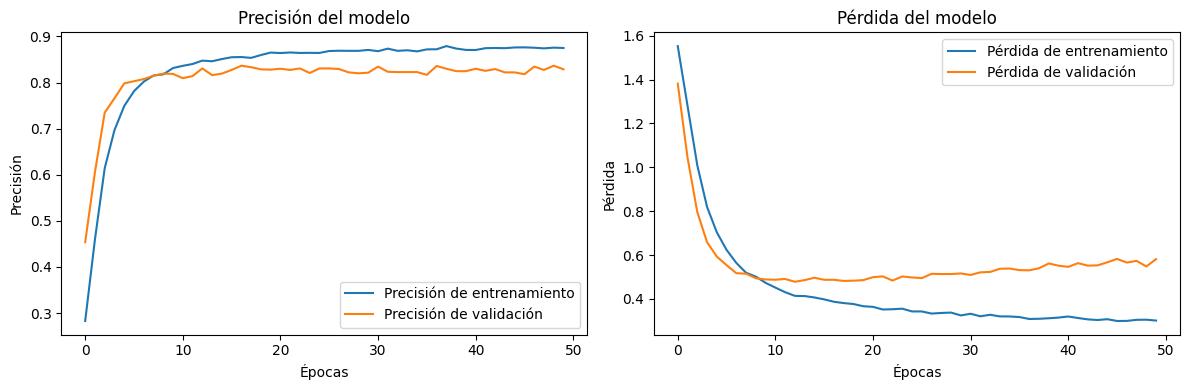

In [87]:
# Graficar la precisión del modelo
plt.figure(figsize=(12, 4))

# Gráfica de la precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de la pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [88]:
# Definir el modelo con hiperparámetros ajustables
def create_model(learning_rate=0.001, activation='relu', dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Crear el modelo con hiperparámetros ajustados
model = create_model(learning_rate=0.0005, activation='tanh', dropout_rate=0.3)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=90, batch_size=64, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/90
79/79 [==============================] - 2s 7ms/step - loss: 1.4925 - accuracy: 0.3514 - val_loss: 1.3576 - val_accuracy: 0.4365
Epoch 2/90
79/79 [==============================] - 0s 4ms/step - loss: 1.2246 - accuracy: 0.5310 - val_loss: 1.1235 - val_accuracy: 0.5906
Epoch 3/90
79/79 [==============================] - 0s 4ms/step - loss: 0.9993 - accuracy: 0.6498 - val_loss: 0.9047 - val_accuracy: 0.7017
Epoch 4/90
79/79 [==============================] - 0s 5ms/step - loss: 0.8137 - accuracy: 0.7204 - val_loss: 0.7660 - val_accuracy: 0.7202
Epoch 5/90
79/79 [==============================] - 1s 9ms/step - loss: 0.7071 - accuracy: 0.7462 - val_loss: 0.7058 - val_accuracy: 0.7295
Epoch 6/90
79/79 [==============================] - 0s 6ms/step - loss: 0.6638 - accuracy: 0.7444 - val_loss: 0.6802 - val_accuracy: 0.7321
Epoch 7/90
79/79 [==============================] - 1s 8ms/step - loss: 0.6257 - accuracy: 0.7563 - val_loss: 0.6674 - val_accuracy: 0.7282
Epoch 8/90
79/79 [==

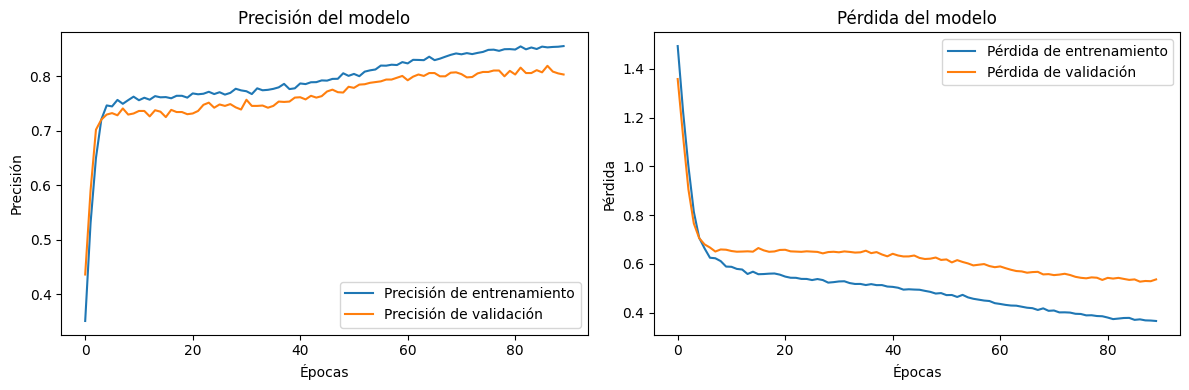

In [89]:
# Graficar la precisión del modelo
plt.figure(figsize=(12, 4))

# Gráfica de la precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de la pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [90]:
# Definir el modelo con hiperparámetros ajustables
def create_simple_model(learning_rate=0.001, dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Crear el modelo con hiperparámetros ajustados
model = create_simple_model(learning_rate=0.001, dropout_rate=0.3)

# Añadir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/50
158/158 [==============================] - 1s 4ms/step - loss: 1.5249 - accuracy: 0.3228 - val_loss: 1.3476 - val_accuracy: 0.4398
Epoch 2/50
158/158 [==============================] - 0s 3ms/step - loss: 1.2293 - accuracy: 0.4901 - val_loss: 1.0435 - val_accuracy: 0.5813
Epoch 3/50
158/158 [==============================] - 0s 3ms/step - loss: 0.9848 - accuracy: 0.6319 - val_loss: 0.8463 - val_accuracy: 0.7130
Epoch 4/50
158/158 [==============================] - 0s 3ms/step - loss: 0.8003 - accuracy: 0.7141 - val_loss: 0.6891 - val_accuracy: 0.7698
Epoch 5/50
158/158 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.7625 - val_loss: 0.6100 - val_accuracy: 0.7897
Epoch 6/50
158/158 [==============================] - 0s 3ms/step - loss: 0.6136 - accuracy: 0.7841 - val_loss: 0.5713 - val_accuracy: 0.7983
Epoch 7/50
158/158 [==============================] - 0s 3ms/step - loss: 0.5658 - accuracy: 0.7994 - val_loss: 0.5380 - val_accuracy: 0.8042
Epoch 

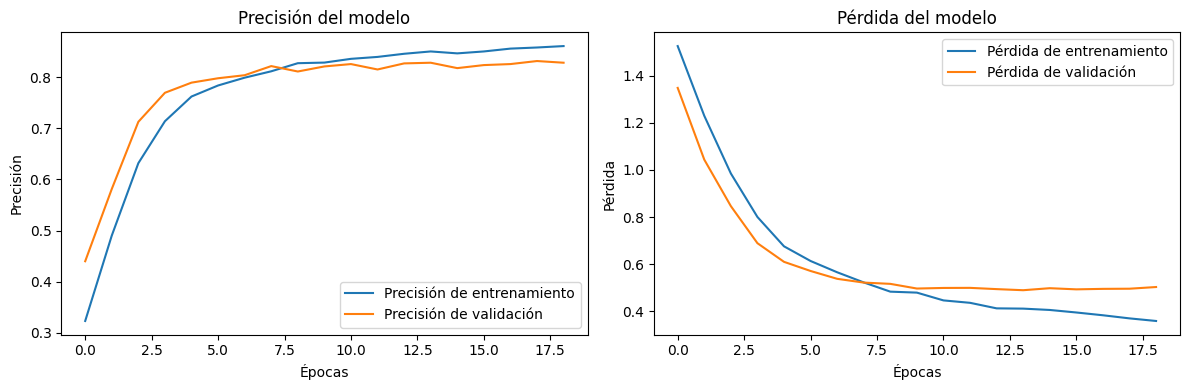

In [91]:
# Graficar la precisión del modelo
plt.figure(figsize=(12, 4))

# Gráfica de la precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de la pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

Ejemplo de prueba para ver qué tan bien predice.

In [ ]:
import numpy as np

# Ejemplo de un registro individual (preprocesado)
# Asegúrate de que el registro individual tenga las mismas características que los datos de entrenamiento y prueba
new_record = X_test.iloc[3]

# Obtener el servicio objetivo original
original_service = y_test.iloc[3].idxmax()

 # Convertir el nuevo registro a un DataFrame
new_record_df = pd.DataFrame([new_record])

# Asegurarse de que tenga las mismas columnas que el DataFrame de entrenamiento
missing_cols = set(X.columns) - set(new_record_df.columns)
for col in missing_cols:
    new_record_df[col] = 0
new_record_df = new_record_df[X.columns]

# Convertir a numpy array
new_record_array = new_record_df.values

# Predecir usando el modelo entrenado
predictions = model.predict(new_record_array)

# Obtener las probabilidades para cada tipo de servicio
service_probabilities = predictions[0]

# Imprimir el servicio objetivo original y las probabilidades
print(f"Original Servicio: {original_service}")
# Imprimir las probabilidades
service_labels = y.columns  # Asegúrate de que 'y' tiene las columnas de las categorías de servicio
for label, prob in zip(service_labels, service_probabilities):
    print(f"Servicio: {label}, Probabilidad: {prob:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Original Servicio: SAAF
Servicio: AT, Probabilidad: 0.0602
Servicio: EM, Probabilidad: 0.0040
Servicio: LOG, Probabilidad: 0.5968
Servicio: SAAF, Probabilidad: 0.1689
Servicio: SO, Probabilidad: 0.1701


In [ ]:
import numpy as np

# Ejemplo de un registro individual (preprocesado)
# Asegúrate de que el registro individual tenga las mismas características que los datos de entrenamiento y prueba
new_record = X_test.iloc[22]

# Obtener el servicio objetivo original
original_service = y_test.iloc[22].idxmax()

 # Convertir el nuevo registro a un DataFrame
new_record_df = pd.DataFrame([new_record])

# Asegurarse de que tenga las mismas columnas que el DataFrame de entrenamiento
missing_cols = set(X.columns) - set(new_record_df.columns)
for col in missing_cols:
    new_record_df[col] = 0
new_record_df = new_record_df[X.columns]

# Convertir a numpy array
new_record_array = new_record_df.values

# Predecir usando el modelo entrenado
predictions = model.predict(new_record_array)

# Obtener las probabilidades para cada tipo de servicio
service_probabilities = predictions[0]

# Imprimir el servicio objetivo original y las probabilidades
print(f"Original Servicio: {original_service}")
# Imprimir las probabilidades
service_labels = y.columns  # Asegúrate de que 'y' tiene las columnas de las categorías de servicio
for label, prob in zip(service_labels, service_probabilities):
    print(f"Servicio: {label}, Probabilidad: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Original Servicio: SAAF
Servicio: AT, Probabilidad: 0.0257
Servicio: EM, Probabilidad: 0.0218
Servicio: LOG, Probabilidad: 0.0342
Servicio: SAAF, Probabilidad: 0.2865
Servicio: SO, Probabilidad: 0.6317


In [ ]:
import numpy as np

# Ejemplo de un registro individual (preprocesado)
# Asegúrate de que el registro individual tenga las mismas características que los datos de entrenamiento y prueba
new_record = X_test.iloc[70]

# Obtener el servicio objetivo original
original_service = y_test.iloc[70].idxmax()

 # Convertir el nuevo registro a un DataFrame
new_record_df = pd.DataFrame([new_record])

# Asegurarse de que tenga las mismas columnas que el DataFrame de entrenamiento
missing_cols = set(X.columns) - set(new_record_df.columns)
for col in missing_cols:
    new_record_df[col] = 0
new_record_df = new_record_df[X.columns]

# Convertir a numpy array
new_record_array = new_record_df.values

# Predecir usando el modelo entrenado
predictions = model.predict(new_record_array)

# Obtener las probabilidades para cada tipo de servicio
service_probabilities = predictions[0]

# Imprimir el servicio objetivo original y las probabilidades
print(f"Original Servicio: {original_service}")
# Imprimir las probabilidades
service_labels = y.columns  # Asegúrate de que 'y' tiene las columnas de las categorías de servicio
for label, prob in zip(service_labels, service_probabilities):
    print(f"Servicio: {label}, Probabilidad: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Original Servicio: EM
Servicio: AT, Probabilidad: 0.0006
Servicio: EM, Probabilidad: 0.9977
Servicio: LOG, Probabilidad: 0.0000
Servicio: SAAF, Probabilidad: 0.0013
Servicio: SO, Probabilidad: 0.0004


In [ ]:
pip install scikeras

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Definir el modelo con hiperparámetros ajustables
def create_nn_model(learning_rate=0.001, dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Crear el KerasClassifier con SciKeras
nn_model = KerasClassifier(model=create_nn_model, verbose=0)

# Definir los hiperparámetros para la búsqueda aleatoria
param_dist_nn = {
    'model__learning_rate': uniform(0.0001, 0.001),
    'model__dropout_rate': uniform(0.1, 0.5),
    'epochs': [50, 100, 200],
    'batch_size': [16, 32, 64]
}

# Realizar la búsqueda aleatoria
random_search_nn = RandomizedSearchCV(estimator=nn_model, param_distributions=param_dist_nn, scoring='accuracy', cv=3, n_iter=20, verbose=1, random_state=42)
random_search_nn.fit(X_train, y_train)

# Obtener el mejor modelo
best_nn_model = random_search_nn.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

In [ ]:
# Evaluar el mejor modelo de red neuronal
best_nn_model_keras = best_nn_model.model_
loss, accuracy = best_nn_model_keras.evaluate(X_test, y_test)
print(f'Best Neural Network Model Loss: {loss}')
print(f'Best Neural Network Model Accuracy: {accuracy}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8329 - loss: 0.6027  
Best Neural Network Model Loss: 0.6062937378883362
Best Neural Network Model Accuracy: 0.834876537322998


##Modelo XGBoost con datos generados

In [92]:
# Codificar las etiquetas usando LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.idxmax(axis=1))  # Convertir de one-hot encoding a etiquetas enteras

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Crear y entrenar el modelo XGBoost
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=len(label_encoder.classes_))
xgb_model.fit(X_train_xgb, y_train_xgb)

# Obtener las predicciones de probabilidad del conjunto de prueba
X_train_nn = xgb_model.predict_proba(X_train_xgb)
X_test_nn = xgb_model.predict_proba(X_test_xgb)

# Convertir las etiquetas del conjunto de prueba a one-hot encoding
y_train_nn = to_categorical(y_train_xgb, num_classes=len(label_encoder.classes_))
y_test_nn = to_categorical(y_test_xgb, num_classes=len(label_encoder.classes_))

# Definir el modelo de red neuronal
def create_nn_model(input_dim, learning_rate=0.001, dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y_train_nn.shape[1], activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Crear el modelo de red neuronal
nn_model = create_nn_model(input_dim=X_train_nn.shape[1])

# Añadir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo de red neuronal
history = nn_model.fit(X_train_nn, y_train_nn, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = nn_model.evaluate(X_test_nn, y_test_nn)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/100
63/63 [==============================] - 2s 10ms/step - loss: 1.2970 - accuracy: 0.6059 - val_loss: 0.7466 - val_accuracy: 0.7996
Epoch 2/100
63/63 [==============================] - 0s 5ms/step - loss: 0.6482 - accuracy: 0.7840 - val_loss: 0.5534 - val_accuracy: 0.8065
Epoch 3/100
63/63 [==============================] - 0s 5ms/step - loss: 0.5761 - accuracy: 0.7971 - val_loss: 0.5400 - val_accuracy: 0.7986
Epoch 4/100
63/63 [==============================] - 0s 3ms/step - loss: 0.5599 - accuracy: 0.8003 - val_loss: 0.5444 - val_accuracy: 0.8075
Epoch 5/100
63/63 [==============================] - 0s 3ms/step - loss: 0.5619 - accuracy: 0.8056 - val_loss: 0.5408 - val_accuracy: 0.8115
Epoch 6/100
63/63 [==============================] - 0s 3ms/step - loss: 0.5562 - accuracy: 0.8100 - val_loss: 0.5373 - val_accuracy: 0.7996
Epoch 7/100
63/63 [==============================] - 0s 4ms/step - loss: 0.5483 - accuracy: 0.8028 - val_loss: 0.5322 - val_accuracy: 0.8056
Epoch 8/100


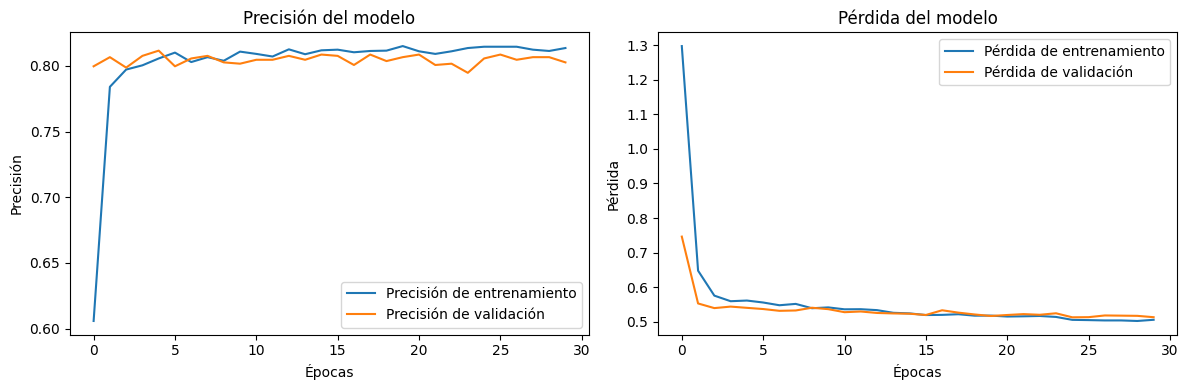

In [93]:
# Graficar la precisión del modelo
plt.figure(figsize=(12, 4))

# Gráfica de la precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de la pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [ ]:
# Ejemplo de un registro individual (preprocesado) con el conjunto de prueba de XGBoost
new_record_xgb = X_test_xgb.iloc[3]

# Convertir el nuevo registro a un DataFrame
new_record_xgb_df = pd.DataFrame([new_record_xgb])

# Obtener las predicciones de probabilidad del modelo XGBoost
new_record_nn_input = xgb_model.predict_proba(new_record_xgb_df)

# Predecir usando el modelo de red neuronal entrenado
predictions = nn_model.predict(new_record_nn_input)

# Obtener las probabilidades para cada tipo de servicio
service_probabilities = predictions[0]

# Obtener el servicio objetivo original
original_service = y_test_xgb[3]  # Indexar directamente el array de NumPy

# Convertir el servicio objetivo original a etiqueta de texto
original_service_label = label_encoder.inverse_transform([original_service])[0]

# Imprimir el servicio objetivo original y las probabilidades
service_labels = label_encoder.classes_  # Obtener las etiquetas originales
print(f"Original Servicio: {original_service_label}")
for label, prob in zip(service_labels, service_probabilities):
    print(f"Servicio: {label}, Probabilidad: {prob:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Original Servicio: SO
Servicio: AT, Probabilidad: 0.2219
Servicio: EM, Probabilidad: 0.1897
Servicio: LOG, Probabilidad: 0.0173
Servicio: SAAF, Probabilidad: 0.3755
Servicio: SO, Probabilidad: 0.1957


In [ ]:
# Ejemplo de un registro individual (preprocesado) con el conjunto de prueba de XGBoost
new_record_xgb = X_test_xgb.iloc[3]

# Convertir el nuevo registro a un DataFrame
new_record_xgb_df = pd.DataFrame([new_record_xgb])

# Obtener las predicciones de probabilidad del modelo XGBoost
new_record_nn_input = xgb_model.predict_proba(new_record_xgb_df)

# Predecir usando el modelo de red neuronal entrenado
predictions = nn_model.predict(new_record_nn_input)

# Obtener las probabilidades para cada tipo de servicio
service_probabilities = predictions[0]

# Obtener el servicio objetivo original
original_service = y_test_xgb[3]  # Indexar directamente el array de NumPy

# Convertir el servicio objetivo original a etiqueta de texto
original_service_label = label_encoder.inverse_transform([original_service])[0]

# Imprimir el servicio objetivo original y las probabilidades
service_labels = label_encoder.classes_  # Obtener las etiquetas originales
print(f"Original Servicio: {original_service_label}")
for label, prob in zip(service_labels, service_probabilities):
    print(f"Servicio: {label}, Probabilidad: {prob:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Original Servicio: SO
Servicio: AT, Probabilidad: 0.2219
Servicio: EM, Probabilidad: 0.1897
Servicio: LOG, Probabilidad: 0.0173
Servicio: SAAF, Probabilidad: 0.3755
Servicio: SO, Probabilidad: 0.1957


In [ ]:
# Ejemplo de un registro individual (preprocesado) con el conjunto de prueba de XGBoost
new_record_xgb = X_test_xgb.iloc[3]

# Convertir el nuevo registro a un DataFrame
new_record_xgb_df = pd.DataFrame([new_record_xgb])

# Obtener las predicciones de probabilidad del modelo XGBoost
new_record_nn_input = xgb_model.predict_proba(new_record_xgb_df)

# Predecir usando el modelo de red neuronal entrenado
predictions = nn_model.predict(new_record_nn_input)

# Obtener las probabilidades para cada tipo de servicio
service_probabilities = predictions[0]

# Obtener el servicio objetivo original
original_service = y_test_xgb[3]  # Indexar directamente el array de NumPy

# Convertir el servicio objetivo original a etiqueta de texto
original_service_label = label_encoder.inverse_transform([original_service])[0]

# Imprimir el servicio objetivo original y las probabilidades
service_labels = label_encoder.classes_  # Obtener las etiquetas originales
print(f"Original Servicio: {original_service_label}")
for label, prob in zip(service_labels, service_probabilities):
    print(f"Servicio: {label}, Probabilidad: {prob:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Original Servicio: SO
Servicio: AT, Probabilidad: 0.2219
Servicio: EM, Probabilidad: 0.1897
Servicio: LOG, Probabilidad: 0.0173
Servicio: SAAF, Probabilidad: 0.3755
Servicio: SO, Probabilidad: 0.1957


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Definir el modelo XGBoost
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=len(label_encoder.classes_))

# Definir los hiperparámetros para la búsqueda aleatoria
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# Realizar la búsqueda aleatoria
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='accuracy', cv=3, n_iter=50, verbose=1, random_state=42)
random_search.fit(X_train_xgb, y_train_xgb)

# Obtener el mejor modelo
best_xgb_model = random_search.best_estimator_

# Obtener las predicciones de probabilidad del conjunto de prueba
X_train_nn = best_xgb_model.predict_proba(X_train_xgb)
X_test_nn = best_xgb_model.predict_proba(X_test_xgb)

# Convertir las etiquetas del conjunto de prueba a one-hot encoding
y_train_nn = to_categorical(y_train_xgb, num_classes=len(label_encoder.classes_))
y_test_nn = to_categorical(y_test_xgb, num_classes=len(label_encoder.classes_))

# Evaluar el mejor modelo XGBoost
best_xgb_accuracy = random_search.best_score_
print(f'Best XGBoost Model Accuracy: {best_xgb_accuracy}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best XGBoost Model Accuracy: 0.7841269841269841


In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Definir el modelo de red neuronal con regularización y Dropout
def create_nn_model(input_dim, learning_rate=0.001, dropout_rate=0.3, regularization=0.01):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(regularization)))
    model.add(Dense(y_train_nn.shape[1], activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Crear el modelo de red neuronal
nn_model = create_nn_model(input_dim=X_train_nn.shape[1], learning_rate=0.001, dropout_rate=0.4, regularization=0.01)

# Añadir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo de red neuronal
history = nn_model.fit(X_train_nn, y_train_nn, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = nn_model.evaluate(X_test_nn, y_test_nn)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/100
63/63 [==============================] - 1s 6ms/step - loss: 2.4367 - accuracy: 0.4593 - val_loss: 1.9117 - val_accuracy: 0.7361
Epoch 2/100
63/63 [==============================] - 0s 3ms/step - loss: 1.5464 - accuracy: 0.7197 - val_loss: 1.1791 - val_accuracy: 0.7976
Epoch 3/100
63/63 [==============================] - 0s 4ms/step - loss: 1.1423 - accuracy: 0.7698 - val_loss: 1.0062 - val_accuracy: 0.7937
Epoch 4/100
63/63 [==============================] - 0s 3ms/step - loss: 1.0246 - accuracy: 0.7902 - val_loss: 0.9520 - val_accuracy: 0.7917
Epoch 5/100
63/63 [==============================] - 0s 4ms/step - loss: 0.9849 - accuracy: 0.7835 - val_loss: 0.9098 - val_accuracy: 0.7976
Epoch 6/100
63/63 [==============================] - 0s 3ms/step - loss: 0.9470 - accuracy: 0.7865 - val_loss: 0.8856 - val_accuracy: 0.8065
Epoch 7/100
63/63 [==============================] - 0s 3ms/step - loss: 0.9217 - accuracy: 0.7845 - val_loss: 0.8661 - val_accuracy: 0.7986
Epoch 8/100
6

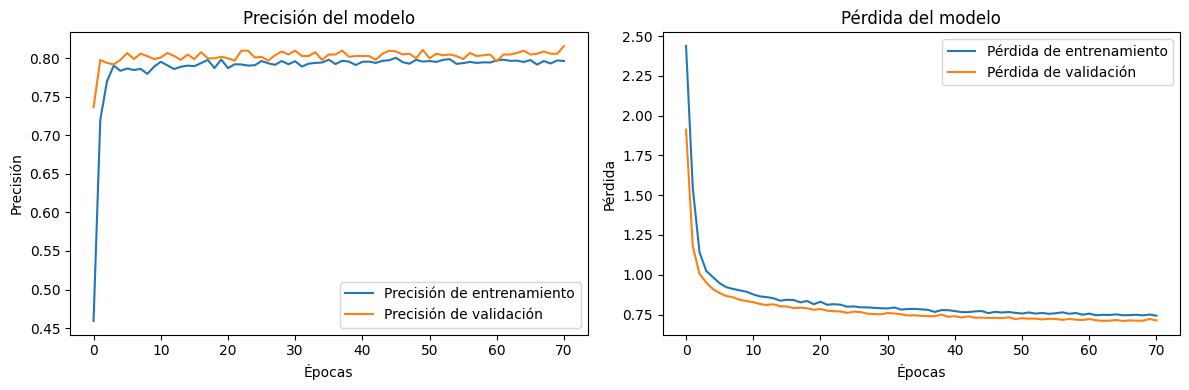

In [95]:
# Graficar la precisión del modelo
plt.figure(figsize=(12, 4))

# Gráfica de la precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de la pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [ ]:
# Ejemplo de un registro individual (preprocesado) con el conjunto de prueba de XGBoost
new_record_xgb = X_test_xgb.iloc[2]

# Convertir el nuevo registro a un DataFrame
new_record_xgb_df = pd.DataFrame([new_record_xgb])

# Obtener las predicciones de probabilidad del modelo XGBoost
new_record_nn_input = best_xgb_model.predict_proba(new_record_xgb_df)

# Predecir usando el modelo de red neuronal entrenado
predictions = nn_model.predict(new_record_nn_input)

# Obtener las probabilidades para cada tipo de servicio
service_probabilities = predictions[0]

# Obtener el servicio objetivo original
original_service = y_test_xgb[2]  # Indexar directamente el array de NumPy

# Convertir el servicio objetivo original a etiqueta de texto
original_service_label = label_encoder.inverse_transform([original_service])[0]

# Imprimir el servicio objetivo original y las probabilidades
service_labels = label_encoder.classes_  # Obtener las etiquetas originales
print(f"Original Servicio: {original_service_label}")
for label, prob in zip(service_labels, service_probabilities):
    print(f"Servicio: {label}, Probabilidad: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Original Servicio: LOG
Servicio: AT, Probabilidad: 0.0049
Servicio: EM, Probabilidad: 0.0015
Servicio: LOG, Probabilidad: 0.9762
Servicio: SAAF, Probabilidad: 0.0049
Servicio: SO, Probabilidad: 0.0125
